<a href="https://colab.research.google.com/github/Sahanaka/SER-EE7209_G14/blob/main/speech_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Speech Emotion Recognition**
In this notebook we will experiment SER on a small subset of RAVDESS dataset.

## **Setup**

In [276]:
!pip install librosa soundfile pyaudio

  Using cached PyAudio-0.2.11.tar.gz (37 kB)
  ERROR: Failed building wheel for pyaudio
  Running setup.py clean for pyaudio
Failed to build pyaudio
    Running setup.py install for pyaudio ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-zi1jt1yi/pyaudio_f3c272773a114a899fcc1d497783360f/setup.py'"'"'; __file__='"'"'/tmp/pip-install-zi1jt1yi/pyaudio_f3c272773a114a899fcc1d497783360f/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-3qsth516/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/pyaudio Check the logs for full command output.


## **Imports**

In [277]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

## **Utilities**

In [278]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Preparation**

In [279]:
audio = "/content/drive/MyDrive/Datasets/RAVDESS_low_sampled/"
actor_folders = os.listdir(audio)
actor_folders

['Actor_21',
 'Actor_17',
 'Actor_22',
 'Actor_15',
 'Actor_19',
 'Actor_24',
 'Actor_23',
 'Actor_18',
 'Actor_16',
 'Actor_20',
 'Actor_05',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_06',
 'Actor_07',
 'Actor_10',
 'Actor_14',
 'Actor_08',
 'Actor_09',
 'Actor_03',
 'Actor_02',
 'Actor_01',
 'Actor_04']

In [280]:
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
def extract_labels_from_file_name():
  emotion = []
  actor = []
  file_path = []

  for i in actor_folders:
      filename = os.listdir(audio + i) # Iterate over Actor folders
      for f in filename: # Go through files in Actor folder
          part = f.split('.')[0].split('-')
          emotion.append(int(part[2]))
          actor.append(int(part[6]))
          file_path.append(audio + i + '/' + f)
  return emotion, actor, file_path

In [281]:
emotion, actor, file_path = extract_labels_from_file_name()

In [282]:
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
def create_main_dataframe(emotion, actor, file_path):
  audio_df = pd.DataFrame(emotion)
  audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
  audio_df = pd.concat([audio_df,pd.DataFrame(actor)], axis=1)
  audio_df.columns = ['emotion', 'actor']
  audio_df = pd.concat([audio_df, pd.DataFrame(file_path, columns=['path'])], axis=1)
  return audio_df

In [283]:
audio_df = create_main_dataframe(emotion, actor, file_path)
audio_df

,emotion,actor,path
0,happy,21,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...
1,disgust,21,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...
2,surprise,21,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...
3,sad,21,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...
4,happy,21,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...
...,...,...,...
1435,angry,4,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...
1436,calm,4,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...
1437,calm,4,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...
1438,fear,4,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...


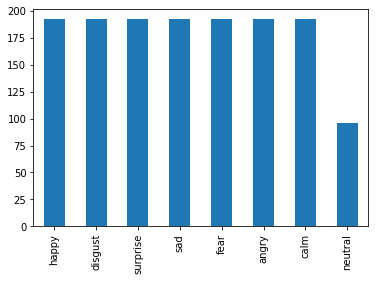

In [284]:
# LOOK AT DISTRIBUTION OF CLASSES
audio_df.emotion.value_counts().plot(kind='bar')

### Feature Extraction

In [285]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
# df = pd.DataFrame(columns=['feature'])

# def mel_spectrogram():
#   counter=0

#   for index,path in enumerate(audio_df.path):
#       X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)

#       #get the mel-scaled spectrogram (transform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
#       spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
#       db_spec = librosa.power_to_db(spectrogram)
#       #temporally average spectrogram
#       log_spectrogram = np.mean(db_spec, axis = 0)

#       df.loc[counter] = [log_spectrogram]

#       counter=counter+1

# def mfcc():
#   counter=0

#   for index,path in enumerate(audio_df.path):
#       X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)

#       # Mel-frequency cepstral coefficients (MFCCs)
#       mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
#       mfcc=np.mean(mfcc,axis=0)

#       df.loc[counter] = [mfcc]

#       counter=counter+1

# def chroma():
#   counter=0

#   for index,path in enumerate(audio_df.path):
#       X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)

#       # compute chroma energy (pertains to 12 different pitch classes)
#       chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
#       chroma = np.mean(chroma, axis = 0)

#       df.loc[counter] = [chroma]

#       counter=counter+1

# def contrast():
#   counter=0

#   for index,path in enumerate(audio_df.path):
#       X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)

#       # compute spectral contrast
#       contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
#       contrast = np.mean(contrast, axis= 0)

#       df.loc[counter] = [contrast]

#       counter=counter+1

# def zcr():
#   counter=0

#   for index,path in enumerate(audio_df.path):
#       X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)

#       # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
#       # which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
#       zcr = librosa.feature.zero_crossing_rate(y=X)
#       zcr = np.mean(zcr, axis= 0)

#       df.loc[counter] = [zcr]

#       counter=counter+1



# def feature_selection(feature):
#   counter=0

#   for index,path in enumerate(audio_df.path):
#       X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
      
#       #get the mel-scaled spectrogram (transform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
#       spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
#       db_spec = librosa.power_to_db(spectrogram)
#       #temporally average spectrogram
#       log_spectrogram = np.mean(db_spec, axis = 0)
          
#       # Mel-frequency cepstral coefficients (MFCCs)
#       mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
#       mfcc=np.mean(mfcc,axis=0)
      
#       # compute chroma energy (pertains to 12 different pitch classes)
#       chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
#       chroma = np.mean(chroma, axis = 0)

#       # compute spectral contrast
#       contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
#       contrast = np.mean(contrast, axis= 0)

#       # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
#       # which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
#       zcr = librosa.feature.zero_crossing_rate(y=X)
#       zcr = np.mean(zcr, axis= 0)
      
#       df.loc[counter] = [log_spectrogram]

#       counter=counter+1   

# def indirect(i):
#         switcher={
#                 0:mel_spectrogram,
#                 1:mfcc,
#                 2:chroma,
#                 3:contrast,
#                 4:zcr
#                 }
#         func=switcher.get(i,lambda :'Invalid')
#         return func()

# indirect(0)

# print(len(df))
# df.head()

In [286]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
# df_combined = pd.concat([audio_df, pd.DataFrame(df['feature'].values.tolist())], axis=1)
# df_combined = df_combined.fillna(0)
# df_combined.head()

In [287]:
# LOAD MEL SPECTOGRAM FROM CSV
df_combined = pd.read_csv('combined_extracted_features.csv')

In [288]:
df_combined.drop(columns='path', inplace=True)
df_combined.head()

,Unnamed: 0,emotion,actor,0,1,2,3,4,5,6,7,8,9,10,11,12,0.1,1.1,2.1,3.1,4.1,5.1,6.1,7.1,8.1,9.1,10.1,11.1,12.1,13,14,15,16,17,18,19,20,21,22,23,...,219.3,220.3,221.3,222.3,223.3,224.3,225.3,226.3,227.3,228.3,229.3,230.3,231.3,232.3,233.3,234.3,235.3,236.3,237.3,238.3,239.3,240.3,241.3,242.3,243.3,244.3,245.3,246.3,247.3,248.3,249.3,250.3,251.3,252.3,253.3,254.3,255.3,256.3,257.3,258.3
0,0,neutral,1,-696.20105,78.316574,3.646741,13.573399,7.353319,14.752226,-4.387536,3.756527,-5.253315,-2.098398,-10.855770,0.928096,1.311461,-76.38477,-76.38477,-76.38477,-76.38477,-76.38477,-76.384770,-76.38477,-76.38477,-76.38477,-76.38477,-76.38477,-76.38477,-76.384770,-76.38477,-76.384770,-76.38477,-76.367455,-76.37206,-76.38477,-76.38477,-76.17391,-75.71910,-75.94153,-75.64262,...,0.355957,0.365723,0.400879,0.355469,0.354492,0.343262,0.220215,0.174805,0.185547,0.121094,0.121094,0.192383,0.116699,0.134766,0.134766,0.037109,0.068848,0.116211,0.151367,0.151367,0.119629,0.047852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,neutral,1,-686.31300,78.732320,0.704220,14.193933,9.702352,14.567476,-5.940362,5.089293,-6.562455,-4.723670,-10.431581,1.062931,1.210753,-75.33552,-75.44532,-75.55403,-75.20395,-75.23053,-75.319374,-75.65379,-75.72004,-75.72004,-75.72004,-75.72004,-75.72004,-75.556015,-75.11806,-75.059260,-75.37063,-75.391230,-75.65184,-75.72004,-75.72004,-75.54712,-75.30135,-75.14379,-75.14993,...,0.201172,0.167969,0.133789,0.023438,0.054688,0.147461,0.143555,0.160156,0.237793,0.191406,0.183594,0.166504,0.138184,0.186523,0.266113,0.266602,0.174316,0.129395,0.073242,0.106445,0.106445,0.080078,0.167969,0.181641,0.194336,0.170898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,neutral,1,-690.26385,80.471260,3.066295,13.347497,6.988072,11.344915,-4.785039,5.105607,-8.027791,-3.109170,-11.353867,-0.487940,-0.265969,-75.15071,-75.15071,-75.15071,-75.15071,-75.15071,-75.150710,-75.15071,-75.13959,-75.07223,-75.15071,-75.15071,-75.15071,-75.150710,-75.09937,-75.150710,-75.15071,-75.150710,-75.10905,-75.09412,-75.15071,-74.92822,-74.15170,-74.19842,-74.51549,...,0.094727,0.094727,0.130859,0.153320,0.183594,0.241211,0.243164,0.198730,0.175781,0.152344,0.114258,0.081055,0.112793,0.119629,0.204102,0.298340,0.313477,0.353027,0.309082,0.214844,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,neutral,1,-688.70215,78.576100,5.858980,15.703995,7.521081,13.692708,-3.470273,6.879573,-7.772521,-3.021198,-10.263145,0.184891,0.613479,-75.26845,-75.26845,-75.26845,-75.26845,-75.26845,-75.268450,-75.26845,-75.26845,-75.26845,-75.26845,-75.26845,-75.26845,-75.268450,-75.26845,-75.243004,-75.26845,-75.268450,-75.26845,-75.26845,-75.26845,-75.26845,-75.24528,-75.04568,-74.99168,...,0.367188,0.359375,0.253418,0.242188,0.242676,0.241699,0.366699,0.381836,0.326660,0.375977,0.246094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,calm,1,-727.78330,87.151090,5.981501,16.521162,7.651807,15.974822,-4.892543,5.531658,-8.175882,-0.301242,-11.974799,-0.529750,0.692740,-80.14738,-80.14738,-80.14738,-80.14738,-80.14738,-80.147380,-80.14738,-80.14738,-80.14738,-80.14738,-80.14738,-80.14738,-80.127945,-80.13347,-80.147380,-80.14738,-80.147380,-80.14738,-80.14738,-80.14738,-79.74190,-79.20434,-79.97592,-80.14738,...,0.341309,0.355957,0.376465,0.416016,0.368652,0.400391,0.353516,0.303711,0.334473,0.289062,0.242188,0.246582,0.202637,0.230469,0.230469,0.203613,0.202148,0.157227,0.219727,0.174316,0.239258,0.226074,0.240234,0.287109,0.169922,0.1

### Data Preparation for modeling

In [289]:
# TRAIN, VALIDATION & TEST SPLITS
def create_data_splits(data_frame, split_size):
  # TRAIN TEST SPLIT DATA
  train_set, test_set = train_test_split(data_frame, test_size=split_size, random_state=42,
                               stratify=data_frame[['emotion', 'actor']])
  # TRAIN VALIDATION SPLIT
  train_set, validation_set = train_test_split(train_set, test_size=0.2, random_state=42)

  return train_set, validation_set, test_set

In [290]:
train, validation, test = create_data_splits(df_combined, split_size=0.2)

In [291]:
print(train.shape)
print(validation.shape)
print(test.shape)

(921, 1052)
(231, 1052)
(288, 1052)


In [292]:
# SEPERATE FEATURES AND LABELS
def create_features_labels_arrays(train, validation, test):
  # Training set
  X_train = train.iloc[:, 3:]
  y_train = train.iloc[:,1]

  # Testing set
  X_test = test.iloc[:,3:]
  y_test = test.iloc[:,1]

  # Validation set
  X_validation = validation.iloc[:,3:]
  y_validation = validation.iloc[:,1]

  return X_train, y_train, X_test, y_test, X_validation, y_validation

In [293]:
X_train, y_train, X_test, y_test, X_validation, y_validation = create_features_labels_arrays(train, validation, test)

In [294]:
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(921, 1049)
(288, 1049)
(231, 1049)


### Data Preprocessing

In [295]:
# NORMALIZE DATA
def normalize(X_train, X_test, X_validation):
  mean = np.mean(X_train, axis=0)
  std = np.std(X_train, axis=0)
  X_train = (X_train - mean) / std
  X_test = (X_test - mean) / std
  X_validation = (X_validation - mean) /std
  return X_train, X_validation, X_test

In [296]:
X_train, X_validation, X_test = normalize(X_train, X_test, X_validation)

In [297]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,0.1,1.1,2.1,3.1,4.1,5.1,6.1,7.1,8.1,9.1,10.1,11.1,12.1,13,14,15,16,17,18,19,20,21,22,23,24,25,26,...,219.3,220.3,221.3,222.3,223.3,224.3,225.3,226.3,227.3,228.3,229.3,230.3,231.3,232.3,233.3,234.3,235.3,236.3,237.3,238.3,239.3,240.3,241.3,242.3,243.3,244.3,245.3,246.3,247.3,248.3,249.3,250.3,251.3,252.3,253.3,254.3,255.3,256.3,257.3,258.3
1036,1.595679,-2.436616,-1.514227,-1.964854,-1.451400,-1.361762,-0.145686,-1.086007,0.908590,-1.193488,-0.884433,-0.116702,-1.133345,1.908320,1.877409,1.860720,1.843677,1.830337,1.796534,1.770156,1.758301,1.756021,1.724252,1.679755,1.666615,1.668402,1.660777,1.632292,1.602934,1.582238,1.565474,1.544443,1.527427,1.515998,1.501640,1.492566,1.486180,1.478685,1.467865,1.451078,...,0.791498,0.887957,0.730481,0.573848,0.748068,0.992606,1.003438,1.127292,1.169929,1.015498,1.061360,1.124727,1.130752,0.996727,0.704995,0.432703,0.371578,0.202311,0.242729,0.317141,0.198716,0.521056,0.772433,0.601764,0.330471,-0.124631,-0.416719,-0.323471,-0.387043,-0.339138,-0.491792,-0.559748,-0.092088,0.192592,0.542643,0.763745,0.676921,0.344159,0.166146,-0.133400
1225,0.847454,1.913956,-0.546146,-0.427904,1.402261,1.207891,-0.360267,-2.791007,0.741631,-1.555200,-3.993871,-0.255719,1.699774,0.584588,0.632287,0.683402,0.643565,0.665542,0.803219,0.890370,1.035452,1.102561,1.141129,1.123858,1.147837,1.114820,1.068122,0.959586,1.037405,1.059095,0.876130,0.599502,0.426132,0.360477,0.282177,0.251388,0.275386,0.250407,0.241289,0.238526,...,-1.337785,-1.360102,-1.372570,-1.375052,-1.377040,-1.366063,-1.375193,-1.382894,-1.373489,-1.372428,-1.369730,-1.350126,-1.354655,-1.338374,-1.286437,-1.277208,-1.280188,-1.233478,-1.228122,-1.216218,-1.158656,-1.154547,-1.159343,-1.098498,-0.944420,-0.877913,-0.732150,-0.530048,-0.536746,-0.339138,-0.296808,-0.157306,0.190579,0.413362,0.722922,0.791900,0.835001,0.800745,0.776432,0.762948
372,-0.828193,1.780544,0.445339,0.540923,1.429144,1.121802,0.644818,0.624466,0.527090,0.857312,2.247252,1.007146,0.395484,0.308432,0.247003,0.087993,0.035210,0.014027,-0.039262,-0.071490,-0.139737,-0.215571,-0.290317,-0.313112,-0.388935,-0.443347,-0.516841,-0.612968,-0.666254,-0.697545,-0.771526,-0.858191,-0.958751,-1.008168,-1.047679,-1.064796,-1.080540,-1.096938,-1.146702,-1.101238,...,0.345969,0.220474,0.301169,0.197389,-0.105436,-0.267862,-0.268650,-0.454270,-0.512149,-0.421839,-0.611802,-0.286223,0.107014,-0.011291,0.206449,0.059431,-0.092895,-0.124865,-0.194992,-0.199445,-0.116195,-0.110685,-0.062784,-0.033528,-0.033410,0.292410,0.240000,0.309332,0.214395,0.154378,0.290780,0.382813,0.570086,0.486952,0.583849,0.694635,0.804405,0.758097,0.729487,0.578767
211,0.188013,-0.782151,-0.651782,-0.477900,-0.875524,-1.542397,-0.271836,-0.378563,-1.006165,-0.937283,-0.173013,-0.506909,-0.130303,0.045544,0.027824,0.023409,0.017334,0.008960,0.000373,-0.005139,-0.008952,-0.018065,-0.030557,-0.044750,-0.053193,-0.057593,-0.063033,-0.069592,-0.077520,-0.087489,-0.098226,-0.106666,-0.113021,-0.111461,-0.094961,-0.092800,-0.083412,-0.090573,-0.112764,-0.113594,...,0.863825,0.879288,1.197504,1.294912,1.356477,1.270778,1.015055,0.877725,0.943718,1.089942,1.130003,0.882931,0.675757,0.530836,0.743557,1.072204,0.775587,0.780953,0.626074,0.661532,1.262895,1.331744,1.214290,1.086800,0.909015,0.983135,1.002725,1.049346,0.836845,0.501667,0.846748,0.859388,1.297692,1.569772,1.351326,1.362695,1.107816,1.187087,1.184268,1.098567
1018,1.233247,-1.432905,0.406614,0.867307,-0.157041,-0.046907,1.231033,0.912411,1.659086,1.430035,0.438456,1.019924,0.725655,1.223691,1.198330,1.180864,1.161816,1.155569,1.125635,1.132091,1.191950,1.305534,1.433137,1.722581,2.016577,2.311575,2.541717,2.672772,2.776946,2.864586,2.922174,2.918787,2.973972,3.037468,3.046799,3.028284,3.014961,2.992766,2.944428,2.860694,...,-1.384074,-1.397666,-1.413181,-1.456135,-1.503912,-1.519637,-1.529122,-1.452541,-1.240083,-0.602221,-0.468797,-0.368718,-0.416229,-0.979780,-0.972435,-0.931384,-0.922901,-0.687284,-0.790401,-0.860894,-0.914329,

In [298]:
X_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,0.1,1.1,2.1,3.1,4.1,5.1,6.1,7.1,8.1,9.1,10.1,11.1,12.1,13,14,15,16,17,18,19,20,21,22,23,24,25,26,...,219.3,220.3,221.3,222.3,223.3,224.3,225.3,226.3,227.3,228.3,229.3,230.3,231.3,232.3,233.3,234.3,235.3,236.3,237.3,238.3,239.3,240.3,241.3,242.3,243.3,244.3,245.3,246.3,247.3,248.3,249.3,250.3,251.3,252.3,253.3,254.3,255.3,256.3,257.3,258.3
950,0.372401,-0.291995,0.754095,0.957032,-0.532724,-0.093363,-1.059571,-0.595938,-0.812016,-0.421142,-0.800980,1.613420,-2.261963,-0.075885,-0.101818,0.314961,1.599697,1.782271,1.138046,0.375403,-0.037121,-0.151771,-0.176058,-0.189200,-0.197292,-0.202110,-0.206970,-0.211870,-0.218321,-0.227392,-0.237623,-0.245306,-0.252753,-0.255129,-0.252308,-0.252675,-0.250551,-0.245311,-0.245377,-0.244694,...,-1.311748,-1.325428,-1.300051,-1.273697,-1.290536,-1.302315,-1.328724,-1.319051,-1.231383,-1.034568,-0.854911,-0.624738,-0.493009,-0.542125,-0.628135,-0.780429,-0.870682,-0.800849,-0.624557,-0.368907,-0.184063,-0.118819,-0.073561,0.074551,0.110572,0.401884,0.689878,0.913372,1.167767,0.890736,0.989034,0.748187,0.899864,1.267529,1.098934,1.022266,0.914041,0.828341,0.811641,0.959408
591,1.647490,0.026977,-0.508224,-0.908246,-1.181309,-0.858178,-2.384094,-0.063995,-1.585490,-0.843484,-1.205886,0.005758,-2.500606,0.816392,0.798511,0.801456,0.810004,0.793905,0.771060,0.741682,0.733145,0.734404,0.714707,0.688987,0.670872,0.663301,0.662306,0.657580,0.651199,0.633984,0.606964,0.585889,0.569095,0.558554,0.553624,0.575393,0.577902,0.575441,0.555739,0.553173,...,-1.311748,-1.360102,-1.375471,-1.398218,-1.405875,-1.400835,-1.410045,-1.400306,-1.367689,-1.372428,-1.398331,-1.412708,-1.462716,-1.456965,-1.410385,-1.414440,-1.414858,-1.357859,-1.358623,-1.224418,-1.123364,-1.075919,-1.046185,-1.111678,-1.161701,-1.172448,-1.156173,-1.170696,-1.156569,-1.140776,-1.145253,-1.136934,-1.099744,-1.087344,-1.028366,-1.027988,-1.026262,-0.972915,-0.963470,-0.956075
840,-0.602793,0.996723,0.712110,-0.217379,1.142873,0.664544,0.765531,0.468729,1.752123,0.666716,0.886961,0.170265,0.569876,-0.360972,-0.385044,-0.472047,-0.560017,-0.534140,-0.544052,-0.515496,-0.475738,-0.549335,-0.586421,-0.573282,-0.566809,-0.600418,-0.613180,-0.633667,-0.644937,-0.638537,-0.651830,-0.655893,-0.626873,-0.590977,-0.589502,-0.607561,-0.594455,-0.561443,-0.541840,-0.525919,...,0.036413,0.078887,-0.157151,-0.390467,-0.537954,-0.172241,-0.106009,-0.106036,0.001175,-0.353121,-0.280030,0.046602,0.078577,-0.062116,0.099027,-0.055843,-0.079153,0.402402,0.506449,0.251543,0.133562,-0.023922,-0.442673,-0.305042,-0.611953,-0.992599,-0.998458,-1.241298,-1.253744,-1.289614,-1.298078,-1.290497,-1.248930,-1.242408,-1.172589,-1.173887,-1.174144,-1.120929,-1.121910,-1.111606
1275,-0.604024,-0.263504,0.381322,-0.424450,-1.035249,0.704154,0.168339,-0.382940,-0.262145,-0.345274,-0.279577,0.431930,0.047548,-0.721952,-0.687810,-0.650598,-0.697068,-0.733488,-0.742351,-0.741930,-0.338701,0.140594,0.101254,0.009548,0.122653,0.320166,0.642866,0.706527,0.594671,0.666762,0.722593,0.749166,0.709750,0.618728,0.548692,0.575374,0.545927,0.460639,0.361724,0.270895,...,0.632381,0.786823,0.820405,0.848952,0.693282,0.433364,0.399341,0.506275,0.415894,0.663322,0.606603,0.362359,0.172420,0.400952,0.302853,0.185685,0.135219,-0.635909,-0.632713,-0.606701,-0.330659,-0.267942,-0.192108,-0.207508,-0.530800,-0.526034,-0.928649,-0.807226,-0.712713,-0.626370,-0.196681,-0.080525,0.389493,0.818105,0.625056,0.305573,0.014005,-0.074796,-0.077382,0.083525
565,0.054742,0.628870,0.133649,-0.065032,0.942717,0.816219,-0.718918,-0.143999,-1.570942,-1.542290,1.472993,-0.151961,-0.433573,1.549869,1.603008,1.562968,1.499751,1.457165,1.474536,1.424409,1.469361,1.535812,1.500054,1.426988,1.456833,1.386238,1.326956,1.308640,1.351497,1.324258,1.298895,1.256366,1.210823,1.160956,1.179510,1.155528,1.174457,1.136871,1.039687,1.030459,...,-0.455405,-0.490352,-0.586464,-0.636613,-0.673477,-0.464901,-0.239607,-0.135056,0.099779,-0.138380,-0.414455,-0.644650,-0.748944,-0.358592,-0.264

In [299]:
X_validation

,0,1,2,3,4,5,6,7,8,9,10,11,12,0.1,1.1,2.1,3.1,4.1,5.1,6.1,7.1,8.1,9.1,10.1,11.1,12.1,13,14,15,16,17,18,19,20,21,22,23,24,25,26,...,219.3,220.3,221.3,222.3,223.3,224.3,225.3,226.3,227.3,228.3,229.3,230.3,231.3,232.3,233.3,234.3,235.3,236.3,237.3,238.3,239.3,240.3,241.3,242.3,243.3,244.3,245.3,246.3,247.3,248.3,249.3,250.3,251.3,252.3,253.3,254.3,255.3,256.3,257.3,258.3
55,-0.839537,-0.285711,0.427719,0.106856,0.176281,-0.156627,0.355157,0.316719,0.425986,0.412805,-0.886533,-0.022397,0.530123,-0.733085,-0.745466,-0.746453,-0.748870,-0.754788,-0.754608,-0.751564,-0.751644,-0.758409,-0.763211,-0.769781,-0.776460,-0.782958,-0.785486,-0.783719,-0.784237,-0.789695,-0.797896,-0.801432,-0.805905,-0.805468,-0.797309,-0.794971,-0.790202,-0.781006,-0.777730,-0.771618,...,-1.126593,-1.140498,-1.155013,-1.056509,-0.881086,-0.893750,-0.901790,-1.083993,-1.472094,-1.203498,-1.209564,-1.082728,-1.152751,-1.259314,-1.074348,-1.189380,-1.189492,-1.268630,-1.410279,-1.404813,-1.378550,-1.382299,-1.377577,-1.335743,-1.331861,-1.318413,-1.295791,-1.309285,-1.306272,-1.289614,-1.298078,-1.290497,-1.248930,-1.242408,-1.172589,-1.173887,-1.174144,-1.120929,-1.121910,-1.111606
1189,-0.063992,-1.347501,-0.385959,-0.477053,-1.056851,-0.857857,-0.756275,-0.441079,-0.322274,-0.266617,-0.332042,-1.151361,-0.496140,0.031046,0.013426,0.009075,0.003067,-0.005261,-0.013684,-0.019037,-0.022780,-0.031850,-0.044199,-0.058249,0.300200,0.434623,0.282403,0.015197,-0.090678,-0.100564,-0.111253,-0.119871,-0.127988,-0.130999,-0.129382,-0.130360,-0.128832,-0.124485,-0.125304,-0.125846,...,-1.164202,-1.157835,-1.076692,-1.047822,-0.915687,-0.815514,-0.483570,-0.309173,-0.161233,0.122173,0.217629,0.874397,1.056815,1.197201,1.310963,0.915759,1.053172,1.021603,0.868044,1.230051,1.243891,1.296496,1.332837,1.123705,1.105353,1.110854,0.951014,0.664957,0.561076,0.642672,0.904717,0.875274,0.837049,0.481695,0.491134,0.715112,0.595331,0.645205,0.327520,0.087618
440,-1.111212,0.181096,1.470441,1.122497,1.037866,1.250657,0.379080,1.833274,-0.454748,1.333053,-0.129844,0.053372,0.399677,-1.105030,-1.103590,-1.128870,-1.023797,-1.025795,-0.936113,-0.908972,-0.927927,-1.089243,-1.068835,-0.979234,-1.005009,-0.971434,-1.045443,-1.035412,-0.982652,-1.087126,-1.118240,-1.211245,-1.212974,-1.162609,-1.144183,-1.138727,-1.094723,-1.092761,-1.107034,-1.094192,...,-1.169988,-1.097155,-1.038983,-1.013072,-0.837834,-0.696711,-0.643307,-0.317878,-0.259838,-0.255772,-0.019760,0.046602,0.439729,0.406599,0.556257,0.528765,0.041775,0.067114,-0.211305,-0.707832,-0.634710,-0.723446,-0.682461,-0.534380,-0.732374,-0.546886,-0.719223,-0.726165,-0.759987,-1.059829,-1.161062,-1.279906,-1.248930,-1.242408,-0.786276,-0.759228,-0.636162,-0.483716,-0.819701,-0.735058
1118,-0.238642,-0.615069,-0.574581,1.717313,-0.516174,0.606042,1.397882,1.014251,-1.506275,0.716846,0.269243,0.163196,-0.048727,-0.706624,-0.709461,-0.709687,-0.714633,-0.730597,-0.741846,-0.701298,-0.693884,-0.691216,-0.686256,-0.664141,-0.680157,-0.710766,-0.718721,-0.738319,-0.738886,-0.726428,-0.726535,-0.726925,-0.730448,-0.744201,-0.739418,-0.744905,-0.760687,-0.745357,-0.734297,-0.738927,...,-1.352250,-1.464126,-1.456692,-1.375052,-1.146364,-1.012553,-1.038293,-1.133326,-1.379290,-1.512726,-1.524176,-1.446844,-1.257969,-1.053193,-0.831961,-0.714557,-0.683793,-0.622389,-0.567463,-0.546569,-0.498973,-0.495694,-0.313349,0.203718,0.513720,1.019626,1.393136,1.221929,0.813207,0.405053,-0.170332,-0.369117,0.253394,0.345028,0.856844,1.214237,1.038975,1.274892,1.304565,1.237726
777,-0.489759,-0.212926,0.950158,0.222769,0.530484,0.652340,1.640699,-0.190333,0.849345,1.345797,0.622234,0.613378,0.845829,-0.304430,-0.319751,-0.322625,-0.319178,-0.297145,-0.301306,-0.328330,-0.333350,-0.322407,-0.327484,-0.360790,-0.352211,-0.346467,-0.356200,-0.368980,-0.360433,-0.362256,-0.386407,-0.416550,-0.413073,-0.410627,-0.402783,-0.408592,-0.401967,-0.389926,-0.388196,-0.380208,...,-0.429368,-0.701288,-0.511044,0.133680,0.713466,0.949141,1.061524,0.709412,0.372392,

In [300]:
# TURN DATA INTO ND ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

In [301]:
# ONE HOT ENCODE THE TARGET
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
y_validation = to_categorical(lb.fit_transform(y_validation))

In [302]:
print(y_train[0:10])
print(y_test[0:10])
print(y_validation[0:10])

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [303]:
X_train.shape

(921, 1049)

In [304]:
X_test.shape

(288, 1049)

In [305]:

X_validation.shape

(231, 1049)

## **Model Building**

In [306]:
# model_1 = Sequential([
#                     Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
#                     Dense(100, activation='relu'),
#                     Dense(8, activation='sigmoid')
# ])

# model_2 = Sequential([Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
#                     Dense(1024, activation='relu'),
#                     Dense(8, activation='softmax')])

model_3 = Sequential()

###first layer
model_3.add(Dense(10,input_shape=(X_train.shape[1],)))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.1))

###second layer
model_3.add(Dense(1024))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.1))

###third layer
# model_3.add(Dense(10240))
# model_3.add(Activation('relu'))
# model_3.add(Dropout(0.5))

###final layer
model_3.add(Dense(8))
model_3.add(Activation('softmax'))


In [307]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_3.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model_3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 10)                10500     
                                                                 
 activation_18 (Activation)  (None, 10)                0         
                                                                 
 dropout_30 (Dropout)        (None, 10)                0         
                                                                 
 dense_31 (Dense)            (None, 1024)              11264     
                                                                 
 activation_19 (Activation)  (None, 1024)              0         
                                                                 
 dropout_31 (Dropout)        (None, 1024)              0         
                                                                 
 dense_32 (Dense)            (None, 8)               

In [308]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=15)

In [309]:
# history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=200, callbacks=[early_stop])
history = model_3.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100, callbacks=[early_stop])

Epoch 1/100
29/29 [==============================] - 1s 12ms/step - loss: 2.0644 - accuracy: 0.1564 - val_loss: 2.0308 - val_accuracy: 0.1905
Epoch 2/100
29/29 [==============================] - 0s 6ms/step - loss: 1.9983 - accuracy: 0.2248 - val_loss: 1.9658 - val_accuracy: 0.2554
Epoch 3/100
29/29 [==============================] - 0s 5ms/step - loss: 1.9195 - accuracy: 0.2964 - val_loss: 1.8787 - val_accuracy: 0.2944
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.8192 - accuracy: 0.3355 - val_loss: 1.7896 - val_accuracy: 0.3247
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 1.7261 - accuracy: 0.3431 - val_loss: 1.7141 - val_accuracy: 0.3506
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 1.6566 - accuracy: 0.3702 - val_loss: 1.6616 - val_accuracy: 0.3723
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 1.6013 - accuracy: 0.4115 - val_loss: 1.6229 - val_accuracy: 0.3983
Epoch 8/100


In [310]:
model_3.evaluate(X_test, y_test)

9/9 [==============================] - 0s 4ms/step - loss: 1.5639 - accuracy: 0.4444


[1.5638813972473145, 0.4444444477558136]

In [311]:
metrics = pd.DataFrame(history.history)

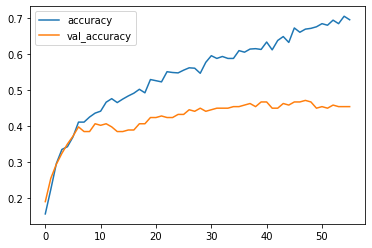

In [312]:
metrics[['accuracy', 'val_accuracy']].plot()

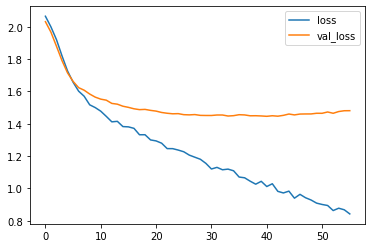

In [313]:
metrics[['loss', 'val_loss']].plot()

### CNN Approach

In [314]:
# ADD NEW DIMENSIONS
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_validation = X_validation[:,:,np.newaxis]

In [315]:
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(921, 1049, 1)
(288, 1049, 1)
(231, 1049, 1)


In [316]:
# BUILD 1D CNN LAYERS
model_cnn = tf.keras.Sequential()
model_cnn.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model_cnn.add(Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(MaxPooling1D(pool_size=(8)))
model_cnn.add(Dropout(0.4))
model_cnn.add(Conv1D(128, kernel_size=(10),activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=(8)))
model_cnn.add(Dropout(0.4))
model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dropout(0.4))
model_cnn.add(Dense(8, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.001)
model_cnn.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 1040, 64)          704       
                                                                 
 conv1d_19 (Conv1D)          (None, 1031, 128)         82048     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 128, 128)         0         
 g1D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 128, 128)          0         
                                                                 
 conv1d_20 (Conv1D)          (None, 119, 128)          163968    
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 14, 128)          0         
 g1D)                                                

In [317]:
cnn_model_history = model_cnn.fit(X_train, y_train,batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/100
29/29 [==============================] - 26s 850ms/step - loss: 2.6784 - accuracy: 0.2258 - val_loss: 2.2215 - val_accuracy: 0.3576
Epoch 2/100
29/29 [==============================] - 15s 523ms/step - loss: 2.0893 - accuracy: 0.3464 - val_loss: 1.8632 - val_accuracy: 0.4132
Epoch 3/100
29/29 [==============================] - 15s 524ms/step - loss: 1.8061 - accuracy: 0.3768 - val_loss: 1.7025 - val_accuracy: 0.3681
Epoch 4/100
29/29 [==============================] - 15s 518ms/step - loss: 1.6600 - accuracy: 0.4159 - val_loss: 1.5725 - val_accuracy: 0.4201
Epoch 5/100
29/29 [==============================] - 15s 521ms/step - loss: 1.5805 - accuracy: 0.4267 - val_loss: 1.5230 - val_accuracy: 0.4375
Epoch 6/100
29/29 [==============================] - 15s 525ms/step - loss: 1.5376 - accuracy: 0.4289 - val_loss: 1.4886 - val_accuracy: 0.4653
Epoch 7/100
29/29 [==============================] - 16s 551ms/step - loss: 1.4560 - accuracy: 0.4615 - val_loss: 1.4863 - val_accuracy:

In [318]:
model_cnn.evaluate(X_test, y_test)

9/9 [==============================] - 1s 129ms/step - loss: 1.3439 - accuracy: 0.5764


[1.3438801765441895, 0.5763888955116272]

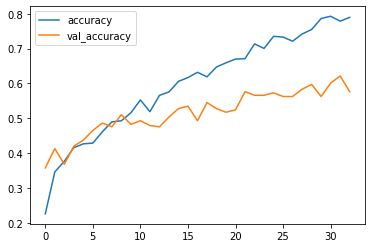

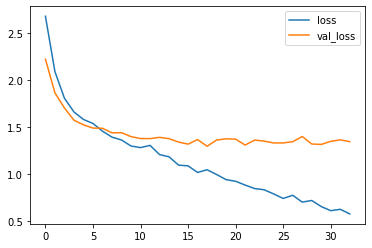

In [319]:
metrics = pd.DataFrame(cnn_model_history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()